# Search: Solving a Maze Using a Goal-based Agent

Student Name: Blake Gebhardt

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: BWG

## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file. 


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [2]:
import maze_helper as mh
import matplotlib

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

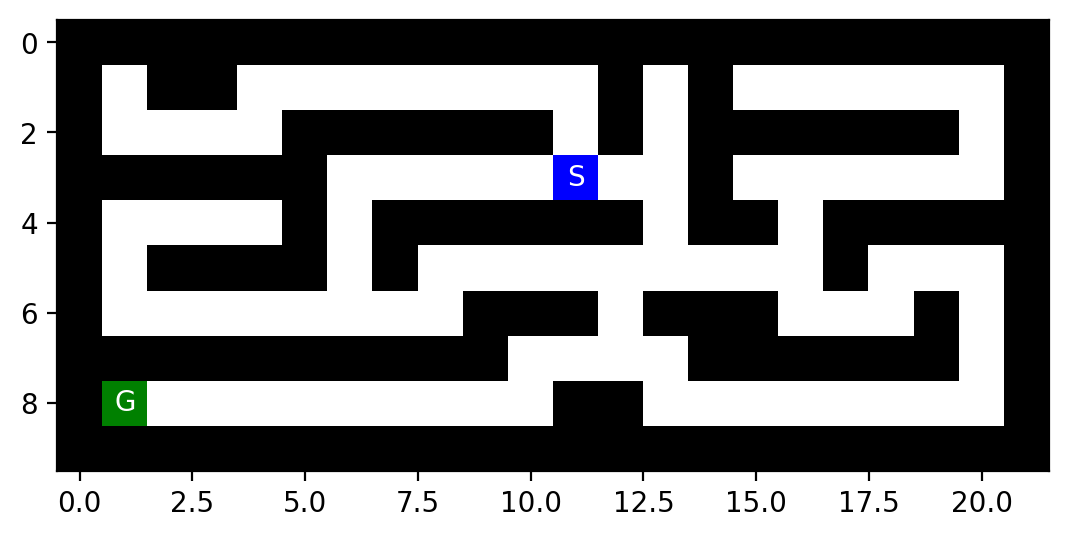

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [5]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /Users/blakegebhardt/Desktop/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

In [7]:
import pathlib
import random
import numpy as np
from matplotlib import colors
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import colors

rc('animation', html='html5')

# numpy comparison warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

class helper:
    @classmethod
    def get_maze(cls, text):
        with open(str(text), "r") as f:
            new_maze = f.read()
        return mh.parse_maze(new_maze)

    @classmethod
    def get_children(cls, node: Node, maze, step_size=0):
        # print('getting children for:', node)
        directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        x = node.pos[0]
        y = node.pos[1]
        res = []
        for direction in directions:
            if len(maze) > x + direction[0] >= 0 and len(maze[0]) > y + direction[1] >= 0:
                if mh.look(maze, (x + direction[0], y + direction[1])) != 'X':
                    res.append(Node((x + direction[0], y + direction[1]), node, None, node.cost + step_size))
        return res

    @classmethod
    def paint(cls, path, maze, value):
        for val in path:
            if maze[val.pos[0]][val.pos[1]] != 'S' and maze[val.pos[0]][val.pos[1]] != 'G':
                maze[val.pos[0]][val.pos[1]] = value

    @classmethod
    def maze_to_matrix(cls, maze):
        """convert a maze a numeric numpy array for visualization via imshow."""
        # make a deep copy first so the original maze is not changed
        maze = np.copy(maze)
        # Converts all tile types to integers
        maze[maze == ' '] = 0
        maze[maze == 'X'] = 1  # wall
        maze[maze == 'S'] = 2  # start
        maze[maze == 'G'] = 3  # goal
        maze[maze == 'P'] = 4  # position/final path
        maze[maze == '.'] = 5  # explored squares
        maze[maze == 'F'] = 6  # frontier
        maze = maze.astype(int)
        return maze

    @classmethod
    def animate_maze(cls, result, fileName, repeat=False):
        """Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays."""
        if result['path'] is not None:
            print(f"Path length: {len(result['path']) - 1}")
            print(f"Reached squares: {len(result['reached'])}")
            # print(f"Action sequence: {result['actions']}")
        else:
            print("No solution found.")

        mazes = result['maze_anim']
        cmap = colors.ListedColormap(['white', 'black', 'blue', 'green', 'red', 'gray', 'orange'])
        goal = mh.find_pos(mazes[0], 'G')
        start = mh.find_pos(mazes[0], 'S')
        mazes = [self.maze_to_matrix(m) for m in mazes]

        fig, ax = mh.plt.subplots()
        im = ax.imshow(self.maze_to_matrix(mazes[0]), cmap=cmap,
                       norm=colors.BoundaryNorm(list(range(cmap.N + 1)), cmap.N))
        mh.plt.text(start[1], start[0], "S", fontsize=10, color="white", horizontalalignment='center',
                     verticalalignment='center')
        mh.plt.text(goal[1], goal[0], "G", fontsize=10, color="white", horizontalalignment='center',
                     verticalalignment='center')

        def step(i):
            im.set_array(self.maze_to_matrix(mazes[i]))
            return [im]

        ani = animation.FuncAnimation(
            fig,
            step,
            frames=len(mazes),
            repeat=repeat
        )

        mh.plt.close()
        ani.save('gifs/' + fileName, writer='ffmeg')  # return ani


# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can switch the next block from code to Markdown and use formatting.

## Task 1

The initial state represents the starting point in the maze from which the search begins.
This can be denoted as a specific cell or position in the maze, in this case an (x, y) coordinate.

In a maze, actions are moving in one of the possible directions: up, down, left, or right.

The maze solver explores possible actions (A(S)) available in the current state. For each action considered, the transitional model  calculates the resulting state (S') by applying the action to the current state: S' = Result(S, A).

The solver checks if the resulting state (S') is valid within the maze and not blocked by walls or obstacles.

The goal state is obviously the goal the solver is trying to reach. It is also represented as an (x, y) coordinate.

The path cost is a numerical value associated with the actions taken to reach a particular state from the initial state.
It represents the cost or distance accumulated along the path.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determine these values for a given maze.

The state space size represents the total number of possible states or configurations in the maze. In a grid-based maze, each cell or node is a potential state.
To calculate n, count the total number of cells in the maze. If the maze is a grid of dimensions R x C (R rows and C columns), then n = R x C.

The depth of the optimal solution is the minimum number of steps or moves required to reach the goal state from the initial state.
You can find d by solving the maze optimally using any suitable algorithm and measuring the number of steps it took to reach the goal from the start.

The maximum depth of the tree represents the deepest level of exploration or recursion in a search tree during the maze-solving process.
m can be calculated by finding the longest path from the start node to any reachable node in the maze using any other traversal algorithm.

The maximum branching factor is the maximum number of child nodes that any node in the search tree can have.
You can determine b by examining the maze's structure. In our grid-based maze, b is equal to the number of adjacent cells that can be reached from a given cell. In our standard 4-connected grid (up, down, left, and right), b = 4.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [8]:
import maze_helper as mh

from collections import deque

def breadth_first(my_maze, make_gif=False, verbose=True):
    start = Node(mh.find_pos(my_maze, what="S"), None, None, 0)
    frontier = deque([start])
    reached = {start}
    frames = []
    
    while frontier:
        if make_gif:
            temp_maze = my_maze.copy()
            helper.paint(reached, temp_maze, '.')
            helper.paint(frontier, temp_maze, 'F')
            frames.append(temp_maze)
        
        node = frontier.popleft()  # Use popleft() to efficiently remove from the front
        children = helper.get_children(node, my_maze)
        
        for child in children:
            found = mh.look(my_maze, child.pos)
            
            if found == 'G':
                completed_path = child.get_path_from_root()
                finished_maze = my_maze.copy()
                helper.paint(completed_path, finished_maze, 'P')
                for _ in range(20):
                    frames.append(finished_maze)
                mh.show_maze(finished_maze)
                
                if make_gif:
                    return {
                        'success': True,
                        'path': completed_path,
                        'maze_anim': frames,
                        'reached': reached
                    }
                else:
                    return
        
            if child not in reached:
                frontier.append(child)
                reached.add(child)
    
    print("Didn't find the end: bfs")
    
def depth_first(my_maze, make_gif=False, verbose=True):
    start = Node(mh.find_pos(my_maze, what="S"), None, None, 0)
    frontier = [start]
    reached = set()
    frames = []

    while frontier:
        node = frontier.pop()  # Pop the top node from the stack

        if node in reached:
            continue  # Skip this node if it has already been visited

        reached.add(node)

        if make_gif:
            temp_maze = my_maze.copy()
            helper.paint(reached, temp_maze, '.')
            helper.paint(frontier, temp_maze, 'F')
            frames.append(temp_maze)

        found = mh.look(my_maze, node.pos)

        if found == 'G':
            completed_path = node.get_path_from_root()
            finished_maze = my_maze.copy()
            helper.paint(completed_path, finished_maze, 'P')
            for _ in range(20):
                frames.append(finished_maze)
            mh.show_maze(finished_maze)

            if make_gif:
                return {
                    'success': True,
                    'path': completed_path,
                    'maze_anim': frames,
                    'reached': reached
                }
        else:
            children = helper.get_children(node, my_maze)
            for child in children:
                if child not in reached:
                    frontier.append(child)

    print("Didn't find the end: dfs")


def dfs_no_reached(my_maze, make_gif=False, verbose=True):
    start = Node(mh.find_pos(my_maze, what="S"), None, None, 0)
    frontier = [start]
    
    while len(frontier) != 0:
        node = frontier.pop()
        children = helper.get_children(node, my_maze)
        
        for child in children:
            found = mh.look(my_maze, child.pos)
            
            if found == 'G':
                completed_path = child.get_path_from_root()
                finished_maze = my_maze.copy()
                helper.paint(completed_path, finished_maze, 'P')
                mh.show_maze(finished_maze)
                return
            
            if child not in node.get_path_from_root():
                frontier.append(child)
    
    print('Didn\'t find the end: dfs')


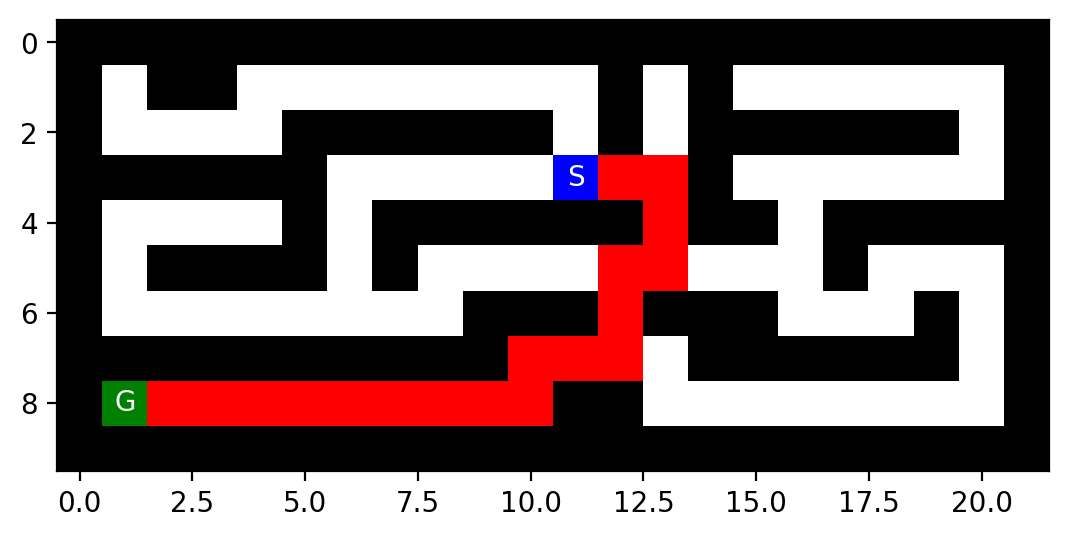

In [9]:
#takes like 40 seconds
my_maze = helper.get_maze('small_maze.txt') 
breadth_first(my_maze)

#takes like 
# my_maze = helper.get_maze('small_maze.txt') 
# depth_first(my_maze)

# my_maze = helper.get_maze('small_maze.txt') 
# dfs_no_reached(my_maze)

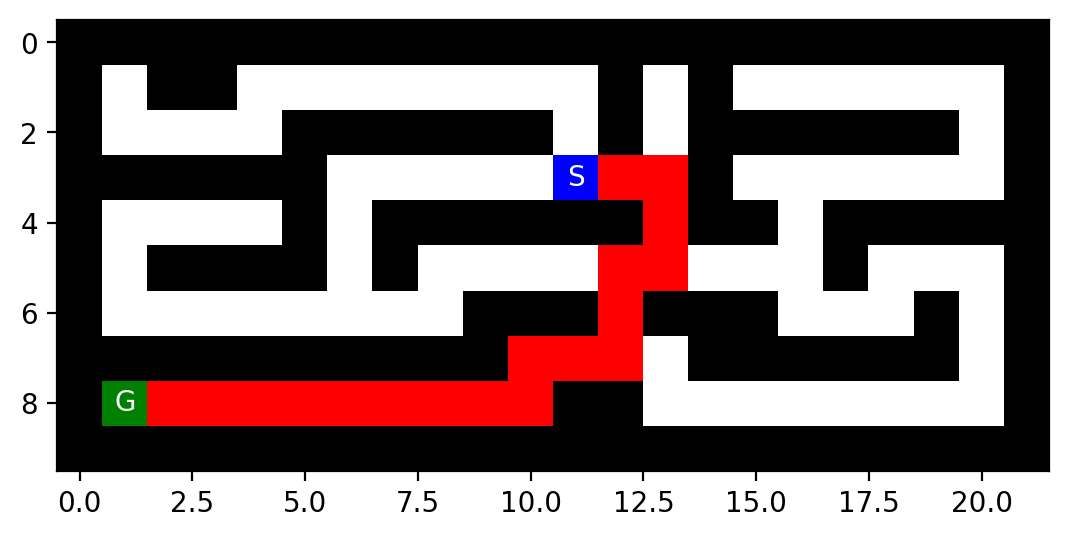

No solution found.


In [10]:
# Run BFS on the maze
solution_path = breadth_first(maze)

# Display the solution path
if solution_path:
    print("Solution path:", solution_path)
else:
    print("No solution found.")



How does BFS and DFS deal with loops (cycles)?

In [11]:
# Discussion

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [12]:
# Discussion

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

In [13]:
# Your code goes here

Are your implementations complete and optimal? What is the time and space complexity?

In [14]:
# Discussion

## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [15]:
# Add code

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)). 

In [16]:
# Add charts

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [17]:
# Add discussion

## Graduate student advanced task: IDS and Multiple goals [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement in addition IDS (iterative deepening search using DFS). 

Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [18]:
# Your code/answer goes here

## More advanced tasks to think about

Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [19]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [20]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [21]:
# Your code/answer goes here